In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sqlalchemy import create_engine
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys, os
this_path = '/home/ibi/Documents/GitHub/ady201m-project'
sys.path.append(this_path)
os.chdir(this_path)

In [2]:
engine = create_engine('sqlite:///src/db/vehicles.db')
df = pd.read_sql_query('SELECT * FROM vehicles', engine)

# df = pd.read_csv('/kaggle/input/cars-data/train-data-cleaned.csv')
df.head()

,Name,Automaker,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage(kmpl),Engine (CC),Power (bhp),Seats,Price
0,Maruti Wagon R LXI CNG,Maruti,Mumbai,2010,72000,CNG,Manual,First,37.24,998,58.16,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.20,5.0,12.50
2,Honda Jazz V,Honda,Chennai,2011,46000,Petrol,Manual,First,18.20,1199,88.70,5.0,4.50
3,Maruti Ertiga VDI,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968,140.80,5.0,17.74


In [3]:
X = df.drop(columns=['Price'])
y = df['Price']

X.head(), y.head()

(                               Name Automaker    Location  Year  \
 0            Maruti Wagon R LXI CNG    Maruti      Mumbai  2010   
 1  Hyundai Creta 1.6 CRDi SX Option   Hyundai        Pune  2015   
 2                      Honda Jazz V     Honda     Chennai  2011   
 3                 Maruti Ertiga VDI    Maruti     Chennai  2012   
 4   Audi A4 New 2.0 TDI Multitronic      Audi  Coimbatore  2013   
 
    Kilometers_Driven Fuel_Type Transmission Owner_Type  Mileage(kmpl)  \
 0              72000       CNG       Manual      First          37.24   
 1              41000    Diesel       Manual      First          19.67   
 2              46000    Petrol       Manual      First          18.20   
 3              87000    Diesel       Manual      First          20.77   
 4              40670    Diesel    Automatic     Second          15.20   
 
    Engine (CC)  Power (bhp)  Seats  
 0          998        58.16    5.0  
 1         1582       126.20    5.0  
 2         1199        88.70  

In [4]:
numerical_columns = ['Year', 'Kilometers_Driven', 'Mileage(kmpl)', 'Engine (CC)', 'Power (bhp)', 'Seats']
categorical_columns = ['Name', 'Automaker', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type']

models = {
    'LinearRegression': (LinearRegression(), {}),
    'DecisionTreeRegressor': (DecisionTreeRegressor(), {'model__max_depth': [3, 5, 7]}),
    'RandomForestRegressor': (RandomForestRegressor(), {'model__n_estimators': [50, 100, 200], 'model__max_depth': [3, 6, 9]}),
    'GradientBoostingRegressor': (GradientBoostingRegressor(), {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.2]}),
    'SVR': (SVR(), {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}),
    'KNeighborsRegressor': (KNeighborsRegressor(), {'model__n_neighbors': [3, 5, 7]}),
    'XGBRegressor': (XGBRegressor(), {'model__n_estimators': [50, 100, 200], 'model__max_depth': [3, 6, 9], 'model__learning_rate': [0.01, 0.1, 0.2]}),
}

In [5]:
def build_preprocessor(selected_features):
    numerical_features = [col for col in selected_features if col in numerical_columns]
    categorical_features = [col for col in selected_features if col in categorical_columns]
    
    return ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

In [6]:
# Evaluating models
feature_list = numerical_columns + categorical_columns
results = {model_name: [] for model_name in models.keys()}
best_estimators = {}
metrics = ['r2_score', 'mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error']
metrics_results = {metric: {model_name: [] for model_name in models.keys()} for metric in metrics}

for i in range(1, len(feature_list) + 1):
    selected_features = feature_list[:i]
    X_selected = X[selected_features]
    
    print(f"Selected features ({i}): {selected_features}")
    
    preprocessor = build_preprocessor(selected_features)
    
    for model_name, (model, params) in tqdm(models.items(), desc=f"Evaluating models with {i} features"):
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('selector', SelectKBest(score_func=f_regression, k='all')),
                                   ('model', model)])
        
        if params:
            grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='r2', n_jobs=-1)
            grid_search.fit(X_selected, y)
            best_model = grid_search.best_estimator_
            best_score = grid_search.best_score_
            best_estimators[model_name] = best_model
            print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        else:
            X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            best_score = r2_score(y_test, y_pred)
            best_estimators[model_name] = pipeline

        results[model_name].append(best_score)
        metrics_results['r2_score'][model_name].append(best_score)
        metrics_results['mean_absolute_error'][model_name].append(mean_absolute_error(y_test, y_pred))
        mse = mean_squared_error(y_test, y_pred)
        metrics_results['mean_squared_error'][model_name].append(mse)
        metrics_results['root_mean_squared_error'][model_name].append(np.sqrt(mse))


Selected features (1): ['Year']


Evaluating models with 1 features:  29%|██▊       | 2/7 [00:02<00:05,  1.17s/it]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 5}


Evaluating models with 1 features:  43%|████▎     | 3/7 [00:04<00:06,  1.62s/it]

Best parameters for RandomForestRegressor: {'model__max_depth': 6, 'model__n_estimators': 100}


Evaluating models with 1 features:  57%|█████▋    | 4/7 [00:06<00:04,  1.62s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.1, 'model__n_estimators': 50}


Evaluating models with 1 features:  86%|████████▌ | 6/7 [00:17<00:03,  3.37s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'auto'}
Best parameters for KNeighborsRegressor: {'model__n_neighbors': 7}


Evaluating models with 1 features: 100%|██████████| 7/7 [00:19<00:00,  2.83s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 50}
Selected features (2): ['Year', 'Kilometers_Driven']


Evaluating models with 2 features:  29%|██▊       | 2/7 [00:00<00:00,  9.51it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 3}


Evaluating models with 2 features:  43%|████▎     | 3/7 [00:05<00:08,  2.14s/it]

Best parameters for RandomForestRegressor: {'model__max_depth': 3, 'model__n_estimators': 50}


Evaluating models with 2 features:  57%|█████▋    | 4/7 [00:09<00:08,  2.88s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.01, 'model__n_estimators': 200}


Evaluating models with 2 features:  86%|████████▌ | 6/7 [00:22<00:04,  4.24s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'scale'}
Best parameters for KNeighborsRegressor: {'model__n_neighbors': 7}


Evaluating models with 2 features: 100%|██████████| 7/7 [00:26<00:00,  3.80s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200}
Selected features (3): ['Year', 'Kilometers_Driven', 'Mileage(kmpl)']


Evaluating models with 3 features:  29%|██▊       | 2/7 [00:00<00:00, 11.04it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 7}
Best parameters for RandomForestRegressor: {'model__max_depth': 9, 'model__n_estimators': 100}


Evaluating models with 3 features:  57%|█████▋    | 4/7 [00:11<00:10,  3.49s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


Evaluating models with 3 features:  86%|████████▌ | 6/7 [00:24<00:04,  4.36s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'scale'}
Best parameters for KNeighborsRegressor: {'model__n_neighbors': 7}


Evaluating models with 3 features: 100%|██████████| 7/7 [00:30<00:00,  4.36s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}
Selected features (4): ['Year', 'Kilometers_Driven', 'Mileage(kmpl)', 'Engine (CC)']


Evaluating models with 4 features:  29%|██▊       | 2/7 [00:00<00:00, 10.22it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 7}
Best parameters for RandomForestRegressor: {'model__max_depth': 9, 'model__n_estimators': 100}


Evaluating models with 4 features:  57%|█████▋    | 4/7 [00:13<00:11,  3.95s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


Evaluating models with 4 features:  86%|████████▌ | 6/7 [00:26<00:04,  4.69s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'scale'}
Best parameters for KNeighborsRegressor: {'model__n_neighbors': 7}


Evaluating models with 4 features: 100%|██████████| 7/7 [00:33<00:00,  4.80s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 200}
Selected features (5): ['Year', 'Kilometers_Driven', 'Mileage(kmpl)', 'Engine (CC)', 'Power (bhp)']


Evaluating models with 5 features:  29%|██▊       | 2/7 [00:00<00:00, 14.29it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 7}
Best parameters for RandomForestRegressor: {'model__max_depth': 9, 'model__n_estimators': 50}


Evaluating models with 5 features:  57%|█████▋    | 4/7 [00:14<00:12,  4.33s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


Evaluating models with 5 features:  86%|████████▌ | 6/7 [00:28<00:05,  5.01s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'auto'}
Best parameters for KNeighborsRegressor: {'model__n_neighbors': 7}


Evaluating models with 5 features: 100%|██████████| 7/7 [00:37<00:00,  5.35s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}
Selected features (6): ['Year', 'Kilometers_Driven', 'Mileage(kmpl)', 'Engine (CC)', 'Power (bhp)', 'Seats']


Evaluating models with 6 features:  29%|██▊       | 2/7 [00:00<00:00, 13.95it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 5}
Best parameters for RandomForestRegressor: {'model__max_depth': 9, 'model__n_estimators': 100}


Evaluating models with 6 features:  57%|█████▋    | 4/7 [00:16<00:14,  4.74s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


Evaluating models with 6 features:  86%|████████▌ | 6/7 [00:30<00:05,  5.27s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'scale'}
Best parameters for KNeighborsRegressor: {'model__n_neighbors': 7}


Evaluating models with 6 features: 100%|██████████| 7/7 [00:38<00:00,  5.50s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 200}
Selected features (7): ['Year', 'Kilometers_Driven', 'Mileage(kmpl)', 'Engine (CC)', 'Power (bhp)', 'Seats', 'Name']


Evaluating models with 7 features:  29%|██▊       | 2/7 [00:00<00:01,  4.12it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 5}


Evaluating models with 7 features:  43%|████▎     | 3/7 [00:29<00:53, 13.36s/it]

Best parameters for RandomForestRegressor: {'model__max_depth': 9, 'model__n_estimators': 100}


Evaluating models with 7 features:  57%|█████▋    | 4/7 [00:40<00:37, 12.38s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


Evaluating models with 7 features:  71%|███████▏  | 5/7 [00:53<00:25, 12.74s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'scale'}


Evaluating models with 7 features:  86%|████████▌ | 6/7 [00:54<00:08,  8.86s/it]

Best parameters for KNeighborsRegressor: {'model__n_neighbors': 3}


Evaluating models with 7 features: 100%|██████████| 7/7 [01:24<00:00, 12.10s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 200}
Selected features (8): ['Year', 'Kilometers_Driven', 'Mileage(kmpl)', 'Engine (CC)', 'Power (bhp)', 'Seats', 'Name', 'Automaker']


Evaluating models with 8 features:  29%|██▊       | 2/7 [00:00<00:01,  4.34it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 7}


Evaluating models with 8 features:  43%|████▎     | 3/7 [00:35<01:03, 15.97s/it]

Best parameters for RandomForestRegressor: {'model__max_depth': 9, 'model__n_estimators': 200}


Evaluating models with 8 features:  57%|█████▋    | 4/7 [00:46<00:42, 14.18s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


Evaluating models with 8 features:  71%|███████▏  | 5/7 [01:00<00:28, 14.06s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'scale'}


Evaluating models with 8 features:  86%|████████▌ | 6/7 [01:01<00:09,  9.71s/it]

Best parameters for KNeighborsRegressor: {'model__n_neighbors': 3}


Evaluating models with 8 features: 100%|██████████| 7/7 [01:32<00:00, 13.15s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 200}
Selected features (9): ['Year', 'Kilometers_Driven', 'Mileage(kmpl)', 'Engine (CC)', 'Power (bhp)', 'Seats', 'Name', 'Automaker', 'Location']


Evaluating models with 9 features:  29%|██▊       | 2/7 [00:00<00:01,  3.29it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 7}


Evaluating models with 9 features:  43%|████▎     | 3/7 [00:38<01:09, 17.40s/it]

Best parameters for RandomForestRegressor: {'model__max_depth': 9, 'model__n_estimators': 200}


Evaluating models with 9 features:  57%|█████▋    | 4/7 [00:49<00:45, 15.06s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


Evaluating models with 9 features:  71%|███████▏  | 5/7 [01:06<00:31, 15.63s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'scale'}


Evaluating models with 9 features:  86%|████████▌ | 6/7 [01:07<00:10, 10.75s/it]

Best parameters for KNeighborsRegressor: {'model__n_neighbors': 3}


Evaluating models with 9 features: 100%|██████████| 7/7 [01:38<00:00, 14.07s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 200}
Selected features (10): ['Year', 'Kilometers_Driven', 'Mileage(kmpl)', 'Engine (CC)', 'Power (bhp)', 'Seats', 'Name', 'Automaker', 'Location', 'Fuel_Type']


Evaluating models with 10 features:  29%|██▊       | 2/7 [00:00<00:01,  2.55it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 7}


Evaluating models with 10 features:  43%|████▎     | 3/7 [00:40<01:13, 18.26s/it]

Best parameters for RandomForestRegressor: {'model__max_depth': 9, 'model__n_estimators': 200}


Evaluating models with 10 features:  57%|█████▋    | 4/7 [00:51<00:47, 15.69s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


Evaluating models with 10 features:  71%|███████▏  | 5/7 [01:10<00:33, 16.58s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'scale'}


Evaluating models with 10 features:  86%|████████▌ | 6/7 [01:11<00:11, 11.44s/it]

Best parameters for KNeighborsRegressor: {'model__n_neighbors': 3}


Evaluating models with 10 features: 100%|██████████| 7/7 [01:42<00:00, 14.70s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 200}
Selected features (11): ['Year', 'Kilometers_Driven', 'Mileage(kmpl)', 'Engine (CC)', 'Power (bhp)', 'Seats', 'Name', 'Automaker', 'Location', 'Fuel_Type', 'Transmission']


Evaluating models with 11 features:  29%|██▊       | 2/7 [00:00<00:01,  2.84it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 7}


Evaluating models with 11 features:  43%|████▎     | 3/7 [00:42<01:17, 19.44s/it]

Best parameters for RandomForestRegressor: {'model__max_depth': 9, 'model__n_estimators': 200}


Evaluating models with 11 features:  57%|█████▋    | 4/7 [00:55<00:49, 16.63s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


Evaluating models with 11 features:  71%|███████▏  | 5/7 [01:14<00:35, 17.51s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'scale'}


Evaluating models with 11 features:  86%|████████▌ | 6/7 [01:15<00:12, 12.01s/it]

Best parameters for KNeighborsRegressor: {'model__n_neighbors': 3}


Evaluating models with 11 features: 100%|██████████| 7/7 [01:47<00:00, 15.38s/it]


Best parameters for XGBRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 200}
Selected features (12): ['Year', 'Kilometers_Driven', 'Mileage(kmpl)', 'Engine (CC)', 'Power (bhp)', 'Seats', 'Name', 'Automaker', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type']


Evaluating models with 12 features:  29%|██▊       | 2/7 [00:00<00:01,  2.91it/s]

Best parameters for DecisionTreeRegressor: {'model__max_depth': 5}


Evaluating models with 12 features:  43%|████▎     | 3/7 [00:38<01:10, 17.56s/it]

Best parameters for RandomForestRegressor: {'model__max_depth': 9, 'model__n_estimators': 100}


Evaluating models with 12 features:  57%|█████▋    | 4/7 [00:51<00:46, 15.55s/it]

Best parameters for GradientBoostingRegressor: {'model__learning_rate': 0.2, 'model__n_estimators': 200}


Evaluating models with 12 features:  71%|███████▏  | 5/7 [01:11<00:34, 17.34s/it]

Best parameters for SVR: {'model__C': 10, 'model__gamma': 'scale'}


Evaluating models with 12 features:  86%|████████▌ | 6/7 [01:13<00:11, 11.96s/it]

Best parameters for KNeighborsRegressor: {'model__n_neighbors': 3}


Evaluating models with 12 features: 100%|██████████| 7/7 [01:45<00:00, 15.11s/it]

Best parameters for XGBRegressor: {'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 200}


In [7]:
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

best_model_name = max(results, key=lambda k: max(results[k]))
with open(f'best_model_{best_model_name}.pkl', 'wb') as f:
    pickle.dump(best_estimators[best_model_name], f)


In [10]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Mean R²': [pd.Series(scores).mean() for scores in results.values()],
    'Max R²': [pd.Series(scores).max() for scores in results.values()],
    'Mean Absolute Error': [pd.Series(metrics_results['mean_absolute_error'][model_name]).mean() for model_name in results.keys()],
    'Mean Squared Error': [pd.Series(metrics_results['mean_squared_error'][model_name]).mean() for model_name in results.keys()],
    'Root Mean Squared Error': [pd.Series(metrics_results['root_mean_squared_error'][model_name]).mean() for model_name in results.keys()]
})

print("Results dataframe:")
results_df

Results dataframe:


,Model,Mean R²,Max R²,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error
0,LinearRegression,0.427798,0.819870,4.205188,70.414927,8.075964
1,DecisionTreeRegressor,0.639991,0.820337,4.205188,70.414927,8.075964
2,RandomForestRegressor,0.707885,0.877097,4.205188,70.414927,8.075964
3,GradientBoostingRegressor,0.724802,0.895626,4.205188,70.414927,8.075964
4,SVR,0.647937,0.886120,4.205188,70.414927,8.075964
5,KNeighborsRegressor,0.661996,0.865279,4.205188,70.414927,8.075964
6,XGBRegressor,0.717756,0.898957,4.205188,70.414927,8.075964


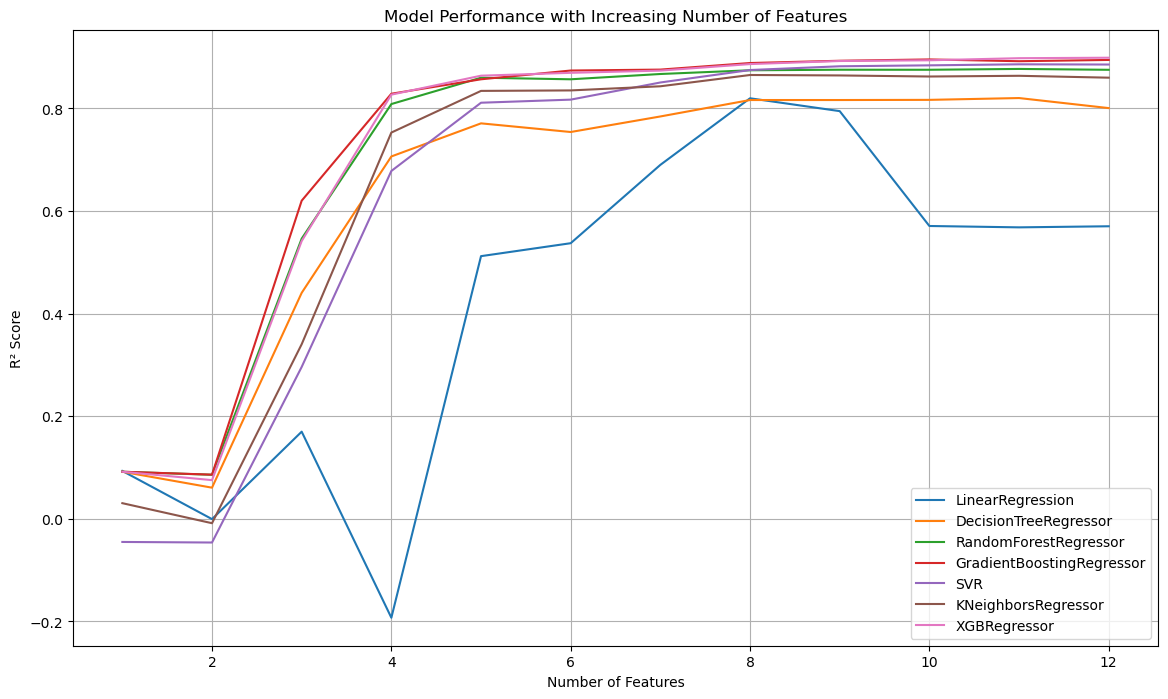

In [9]:
plt.figure(figsize=(14, 8))
for model_name, r2_scores in results.items():
    plt.plot(range(1, len(feature_list) + 1), r2_scores, label=model_name)

plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.title('Model Performance with Increasing Number of Features')
plt.legend()
plt.grid(True)
plt.show()